In [19]:
from molmap.model import RegressionEstimator, MultiClassEstimator, MultiLabelEstimator
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from chembench import dataset
from sklearn.utils import shuffle 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from molmap import MolMap

def Rdsplit(df, random_state = 888, split_size = [0.8, 0.1, 0.1]):
    base_indices = np.arange(len(df)) 
    base_indices = shuffle(base_indices, random_state = random_state) 
    nb_test = int(len(base_indices) * split_size[2]) 
    nb_val = int(len(base_indices) * split_size[1]) 
    test_idx = base_indices[0:nb_test] 
    valid_idx = base_indices[(nb_test):(nb_test+nb_val)] 
    train_idx = base_indices[(nb_test+nb_val):len(base_indices)] 
    print(len(train_idx), len(valid_idx), len(test_idx)) 
    return train_idx, valid_idx, test_idx 

In [2]:
data = dataset.load_ESOL()

total samples: 1128


In [3]:
mp = MolMap(ftype='descriptor',metric='cosine',)

In [4]:
mp.fit(verbose=0, method='umap', min_dist=0.1, n_neighbors=15,)

2021-03-31 10:29:01,510 - INFO - [bidd-molmap] - Applying grid feature map(assignment), this may take several minutes(1~30 min)
2021-03-31 10:29:03,927 - INFO - [bidd-molmap] - Finished


In [5]:
X = mp.batch_transform(data.x)

100%|##########| 1128/1128 [04:46<00:00,  2.90it/s]


In [6]:
Y = data.y

In [8]:
train_idx, valid_idx, test_idx  = Rdsplit(data.df, random_state = 888)
trainX = X[train_idx]
trainY = Y[train_idx]
validX = X[valid_idx]
validY = Y[valid_idx]
testX = X[test_idx]
testY = Y[test_idx]

904 112 112


In [32]:
# define your model
clf = RegressionEstimator(n_outputs=trainY.shape[1], 
                          fmap_shape1 = trainX.shape[1:], 
                          dense_layers = [128, 64],  
                          batch_size = 8,
                          y_scale= None, 
                          patience = 20, 
                          gpuid = 1) 

RegressionEstimator(batch_size=8, gpuid='1', patience=20)


In [33]:
# fit your model
clf.fit(trainX, trainY, validX, validY)

epoch: 0001, loss: 5.4672 - val_loss: 3.8865; rmse: 2.0240 - rmse_val: 1.9714;  r2: 0.4001 - r2_val: 0.3690                                                                                                    
epoch: 0002, loss: 3.8308 - val_loss: 3.2697; rmse: 1.8406 - rmse_val: 1.8082;  r2: 0.4249 - r2_val: 0.3721                                                                                                    
epoch: 0003, loss: 3.0293 - val_loss: 2.5779; rmse: 1.6007 - rmse_val: 1.6056;  r2: 0.5106 - r2_val: 0.4504                                                                                                    
epoch: 0004, loss: 2.1995 - val_loss: 2.2505; rmse: 1.4692 - rmse_val: 1.5002;  r2: 0.6367 - r2_val: 0.5689                                                                                                    
epoch: 0005, loss: 1.7716 - val_loss: 2.1318; rmse: 1.4421 - rmse_val: 1.4601;  r2: 0.6673 - r2_val: 0.6430                                                             

RegressionEstimator(batch_size=8, gpuid='1', patience=20)

<AxesSubplot:>

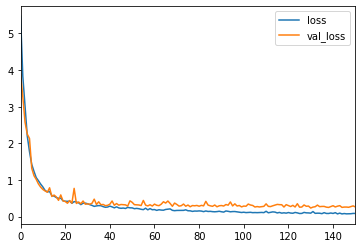

In [34]:
pd.DataFrame(clf.history.history).plot()

In [35]:
print('Best epochs: %.2f, Best MSE: %.2f' % (clf._performance.best_epoch, clf._performance.best))

Best epochs: 130.00, Best MSE: 0.23


In [36]:
testY_pred = clf.predict(testX)

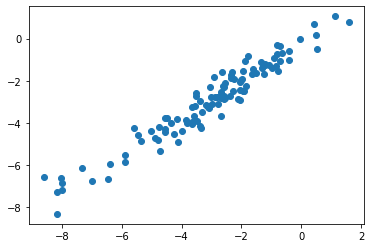

In [37]:
plt.scatter(testY, testY_pred)

In [38]:
rmse, r2 = clf._performance.evaluate(testX, testY)
rmse, r2

([0.5598364810998153], [0.932323885893874])

In [39]:
clf.score(testX, testY)

0.932323885893874

In [40]:
clf._performance.evaluate(validX, validY)

([0.4841993583649496], [0.9436707998060943])